In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import ktrain
from ktrain import tabular
import pandas as pd
pd.set_option('display.max_columns', None)

# Classification and Regression on Tabular Data in `ktrain`

As of v0.19.x, *ktrain* supports classification and regression on "traditional" tabular datasets.

Let's begin with a demonstration of tabular classfication using the well-studied Titatnic dataset from Kaggle.

## Part I:  Classification for Tabular Data



### Solving the Titanic Kaggle Challenge in `ktrain`

This notebook demonstrates using *ktrain* for predicting which passengers survived the Titatnic shipwreck.

The dataset can be [downloaded from Kaggle here](https://www.kaggle.com/c/titanic/overview). There is a `train.csv` with labels (i.e., `Survived`) and a `test.csv` with no labels.  We will only use `train.csv` in this notebook.

Let's begin by loading the data as a pandas DataFrame and inspecting it.

In [3]:
train_df = pd.read_csv('data/titanic/train.csv', index_col=0)

In [4]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We'll drop the `Name` and `Ticket` columns, as they seem like they'll be less predictive.

In [5]:
train_df = train_df.drop('Name', 1)
train_df = train_df.drop('Ticket', 1)

*ktrain* will automatically split out a validation set if given only a training set.  But, let's also manually split out a test set that we can evaluate later.

In [6]:
import numpy as np
np.random.seed(42)
p = 0.1 # 10% for test set
prop = 1-p
df = train_df.copy()
msk = np.random.rand(len(df)) < prop
train_df = df[msk]
test_df = df[~msk]

In [7]:
train_df.shape

(799, 9)

In [8]:
test_df.shape

(92, 9)

### STEP 1: Load and Preprocess the Data

In [9]:
trn, val, preproc = tabular.tabular_from_df(train_df, label_columns=['Survived'], random_state=42)

processing train: 717 rows x 9 columns
processing test: 82 rows x 9 columns


*ktrain* automatically preprocesses the dataset appropriately.  Numerical columns are automatically normalized, missing values are handled, and categorical variables will be vectorized as [entity embeddings](https://arxiv.org/abs/1604.06737) for input to a neural network. The processed DataFrame is shown below (categorical variables will be vectorized on-the-fly, so they appear in their original form).

In [10]:
trn.df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,0,1,Age_na
PassengerId,,,,,,,,,,,
1,3,male,-0.583729,1,0,-0.485473,NaN,S,1.0,0.0,False
4,1,female,0.417180,1,0,0.378614,C123,S,0.0,1.0,False
5,3,male,0.417180,0,0,-0.470396,NaN,S,1.0,0.0,False
6,3,male,-0.121771,0,0,-0.462701,NaN,Q,1.0,0.0,True
7,1,male,1.880046,0,0,0.355292,E46,S,1.0,0.0,False


### STEP 2: Create a Model and Wrap in `Learner`

*ktrain* uses multilayer perceptrons as the model for tabular datasets. The model can be configured with arguments to `tabular_classifier` (e.g., number and size of hidden layers, dropout values, etc.), but we will leave the defaults here.

In [11]:
tabular.print_tabular_classifiers()

mlp: a configurable multilayer perceptron with categorical variable embeddings [https://arxiv.org/abs/1604.06737]


In [12]:
model = tabular.tabular_classifier('mlp', trn)

Is Multi-Label? False
done.


In [13]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=32)

### STEP 3: Estimate the Learning Rate

Based on the plot, we will choose a learning rate of `1e-3`.

simulating training for different learning rates... this may take a few moments...
Train for 22 steps
Epoch 1/8
22/22 [==============================] - 2s 80ms/step - loss: 1.1779 - accuracy: 0.5518
Epoch 2/8
22/22 [==============================] - 1s 23ms/step - loss: 1.1721 - accuracy: 0.5460
Epoch 3/8
22/22 [==============================] - 1s 24ms/step - loss: 1.0120 - accuracy: 0.5985
Epoch 4/8
22/22 [==============================] - 1s 24ms/step - loss: 0.8339 - accuracy: 0.6759
Epoch 5/8
22/22 [==============================] - 1s 24ms/step - loss: 1.0523 - accuracy: 0.7007
Epoch 6/8
22/22 [==============================] - 1s 23ms/step - loss: 1.0305 - accuracy: 0.7197
Epoch 7/8
17/22 [======================>.......] - ETA: 0s - loss: 4.8604 - accuracy: 0.6552

done.
Visually inspect loss plot and select learning rate associated with falling loss


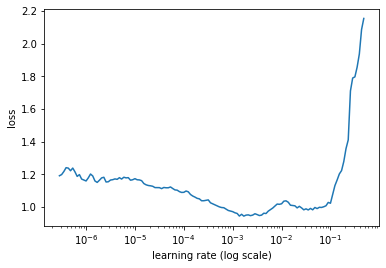

In [14]:
learner.lr_find(show_plot=True, max_epochs=8)

### STEP 4: Train the Model

In [16]:
learner.fit_onecycle(1e-3, 28)



begin training using onecycle policy with max lr of 0.001...
Train for 23 steps, validate for 3 steps
Epoch 1/28
23/23 [==============================] - 1s 29ms/step - loss: 0.2936 - accuracy: 0.8675 - val_loss: 0.3722 - val_accuracy: 0.8537
Epoch 2/28
23/23 [==============================] - 1s 28ms/step - loss: 0.3005 - accuracy: 0.8563 - val_loss: 0.3660 - val_accuracy: 0.8659
Epoch 3/28
23/23 [==============================] - 1s 27ms/step - loss: 0.2986 - accuracy: 0.8759 - val_loss: 0.3659 - val_accuracy: 0.8659
Epoch 4/28
23/23 [==============================] - 1s 28ms/step - loss: 0.2788 - accuracy: 0.8842 - val_loss: 0.3595 - val_accuracy: 0.8659
Epoch 5/28
23/23 [==============================] - 1s 28ms/step - loss: 0.2923 - accuracy: 0.8745 - val_loss: 0.3385 - val_accuracy: 0.8902
Epoch 6/28
23/23 [==============================] - 1s 28ms/step - loss: 0.2885 - accuracy: 0.8954 - val_loss: 0.3517 - val_accuracy: 0.8780
Epoch 7/28
23/23 [==============================] 

**Let's evaluate the validation set:**

In [17]:
learner.evaluate(val, class_names=preproc.get_classes())

              precision    recall  f1-score   support

           0       0.87      0.96      0.91        49
           1       0.93      0.79      0.85        33

    accuracy                           0.89        82
   macro avg       0.90      0.87      0.88        82
weighted avg       0.89      0.89      0.89        82



array([[47,  2],
       [ 7, 26]])

### Make Predictions

The `Predictor` for tabular datasets accepts input as a dataframe in the same format as the original training dataframe. 

We will use `test_df` that we created earlier.

In [18]:
p = ktrain.get_predictor(learner.model, preproc)

In [19]:
preds = p.predict(test_df, return_proba=True)

In [20]:
preds.shape

(92, 2)

In [21]:
print('test accuracy:')
(np.argmax(preds, axis=1) == test_df['Survived'].values).sum()/test_df.shape[0]

test accuracy:


0.8478260869565217

**Our final results as a DataFrame:**

In [22]:
df = test_df.copy()[[c for c in test_df.columns.values if c != 'Survived']]
df['Survived'] = test_df['Survived']
df['predicted_Survived'] = np.argmax(preds, axis=1)
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived,predicted_Survived
PassengerId,,,,,,,,,,
2,1,female,38.0,1,0,71.2833,C85,C,1,1
12,1,female,58.0,0,0,26.5500,C103,S,1,1
34,2,male,66.0,0,0,10.5000,NaN,S,0,0
35,1,male,28.0,1,0,82.1708,NaN,C,0,0
44,2,female,3.0,1,2,41.5792,NaN,C,1,1


## Part II:  Regression for Tabular Data

We will briefly demonstrate tabular regression in *ktrain* by simply predicting the `age` attribute in the Census dataset available from te UCI Machine Learning repository.  This is the same example used in the [AutoGluon regression example](https://autogluon.mxnet.io/tutorials/tabular_prediction/tabular-quickstart.html#regression-predicting-numeric-table-columns). Let's begin by downloading the dataset from the AutoGluon website.

In [27]:
import urllib.request
urllib.request.urlretrieve('https://autogluon.s3.amazonaws.com/datasets/Inc/train.csv', 
                           '/tmp/train.csv')
!ls /tmp/train.csv

/tmp/train.csv


### STEP 1: Load and Preprocess Data

Make sure you specify `is_regression=True` here as we are predicting a numerical dependent variable (i.e., `age`).

In [36]:
trn, val, preproc = tabular.tabular_from_csv('/tmp/train.csv', label_columns='age', 
                                             is_regression=True, random_state=42)

processing train: 35179 rows x 15 columns
processing test: 3894 rows x 15 columns


/home/amaiya/projects/ghub/ktrain/ktrain/utils.py:556: UserWarning: Task is being treated as REGRESSION because either class_names argument was not supplied or is_regression=True. If this is incorrect, change accordingly.
  'If this is incorrect, change accordingly.')


In [47]:
trn.df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,-0.109104,Bachelors,13,Never-married,Tech-support,Own-child,White,Female,-0.145538,-0.2177,-0.033776,United-States,<=50K
2,46,Private,1.774059,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,-0.145538,-0.2177,-2.056852,United-States,<=50K
3,55,?,0.097500,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,-0.145538,-0.2177,0.775455,United-States,>50K
4,36,Private,0.328310,7th-8th,4,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,-0.145538,-0.2177,-0.033776,El-Salvador,<=50K
5,51,Private,-0.113131,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,-0.145538,-0.2177,-0.033776,?,>50K


### STEP 2: Create a Model and Wrap in `Learner`

We'll use `tabular_regression_model` to create a regression model.

In [43]:
tabular.print_tabular_regression_models()

mlp: a configurable multilayer perceptron with categorical variable embeddings [https://arxiv.org/abs/1604.06737]


In [44]:
model = tabular.tabular_regression_model('mlp', trn)
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=128)

done.


### STEP 3: Estimate Learning Rate

simulating training for different learning rates... this may take a few moments...
Train for 274 steps
Epoch 1/1024
274/274 [==============================] - 9s 32ms/step - loss: 1683.1303 - mae: 38.6500
Epoch 2/1024
274/274 [==============================] - 7s 27ms/step - loss: 1673.2442 - mae: 38.6340
Epoch 3/1024
274/274 [==============================] - 7s 27ms/step - loss: 1600.5468 - mae: 38.2733
Epoch 4/1024
274/274 [==============================] - 7s 27ms/step - loss: 765.4320 - mae: 23.0305
Epoch 5/1024
274/274 [==============================] - 7s 26ms/step - loss: 126.8937 - mae: 8.8047
Epoch 6/1024
195/274 [====================>.........] - ETA: 2s - loss: 335.0149 - mae: 11.2219

done.
Visually inspect loss plot and select learning rate associated with falling loss


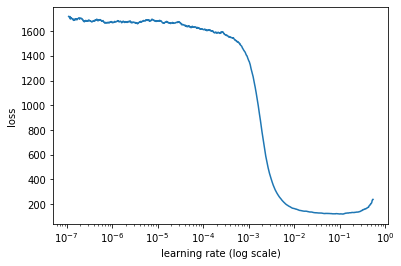

In [45]:
learner.lr_find(show_plot=True)

### STEP 4: Train the Model

According to our final validation MAE (see below), our age predictions are only off about **7 years**.

In [46]:
learner.autofit(1e-3)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Train for 275 steps, validate for 122 steps
Epoch 1/1024
275/275 [==============================] - 12s 42ms/step - loss: 1293.8309 - mae: 33.9090 - val_loss: 888.1002 - val_mae: 26.9798
Epoch 2/1024
275/275 [==============================] - 10s 36ms/step - loss: 400.4217 - mae: 16.2390 - val_loss: 136.2297 - val_mae: 8.6533
Epoch 3/1024
275/275 [==============================] - 10s 36ms/step - loss: 143.6826 - mae: 9.3167 - val_loss: 97.3901 - val_mae: 7.5087
Epoch 4/1024
275/275 [==============================] - 10s 36ms/step - loss: 135.2904 - mae: 9.1053 - val_loss: 97.0960 - val_mae: 7.5041
Epoch 5/1024
275/275 [==============================] - 10s 36ms/step - loss: 130.7182 - mae: 8.9205 - val_loss: 95.5434 - val_mae: 7.4476
Epoch 6/1024
275/275 [==============================] - 10s 36ms/step -